In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.dates import MonthLocator, DateFormatter
from collections import defaultdict

In [ ]:
#change folder path here
path = '/'

#file paths to 20K samples
path_fi = path + 'Data/04_Data_Analysis/20k_finnish_predicted.csv'
path_se = path + 'Data/04_Data_Analysis/20k_swedish_predicted.csv'
path_de = path + 'Data/04_Data_Analysis/20k_german_predicted.csv'
path_en = path + 'Data/04_Data_Analysis/20k_english_predicted.csv'
path_dk = path + 'Data/04_Data_Analysis/20k_danish_predicted.csv'

# Read each csv into a dataframe
df_en = pd.read_csv(path_en, sep='\t', encoding='utf-16')
df_fi = pd.read_csv(path_fi, sep='\t', encoding='utf-16')
df_se = pd.read_csv(path_se, sep='\t', encoding='utf-16')
df_de = pd.read_csv(path_de, sep='\t', encoding='utf-16')
df_dk = pd.read_csv(path_dk, sep='\t', encoding='utf-16')

# Concatenate all the DataFrames
dfs = [df_en, df_fi, df_se, df_de, df_dk]
df = pd.concat(dfs, ignore_index=True)

In [ ]:
df['predicted_label'] = df['predicted_label'].apply(ast.literal_eval)
df['Date'] = pd.to_datetime(df['Date'])

#Number of Tweets Over Time for Each Language (EDA)

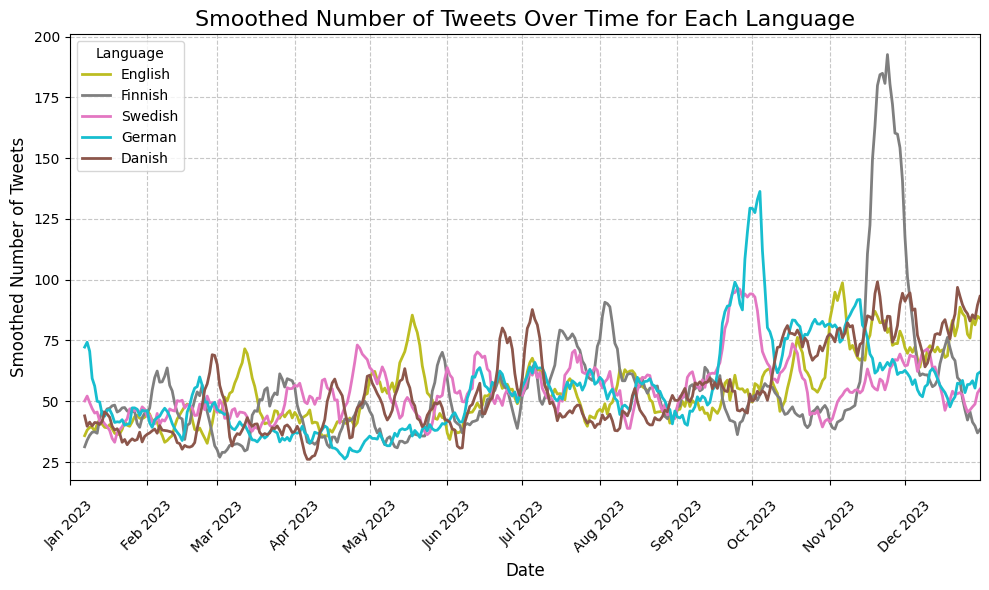

In [ ]:
# ALL COUNTRIES SMOOTHED

# Group data by date and language, and count the number of tweets
tweet_counts = df.groupby([df['Date'].dt.date, 'Language']).size()

# Unstack the multi-indexed DataFrame to have one line per language
tweet_counts_unstacked = tweet_counts.unstack()

# Smooth the lines using a 7-day moving average for each language
smoothed_tweet_counts = tweet_counts_unstacked.rolling(window=7).mean()


# Plot the smoothed number of tweets over time for each language
plt.figure(figsize=(10, 6))

desired_order = ['English', 'Finnish', 'Swedish', 'German', 'Danish']
smoothed_tweet_counts_reordered = smoothed_tweet_counts[desired_order]

colors = ['tab:olive', 'tab:gray', 'tab:pink', 'tab:cyan', 'tab:brown']
smoothed_tweet_counts_reordered.plot(ax=plt.gca(), linewidth=2, color=colors)

plt.title('Smoothed Number of Tweets Over Time for Each Language', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Smoothed Number of Tweets', fontsize=12)

plt.xticks(rotation=45, fontsize=10)
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.gca().xaxis.set_tick_params(which='major', pad=10)  # Adjust padding
plt.xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-31'))

plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# Analysis on the overall dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Unnamed: 0       100000 non-null  int64         
 1   Date             100000 non-null  datetime64[ns]
 2   URL              100000 non-null  object        
 3   Hit Sentence     100000 non-null  object        
 4   Language         100000 non-null  object        
 5   Sentiment        100000 non-null  object        
 6   Translation      100000 non-null  object        
 7   predicted_label  100000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 6.1+ MB


In [ ]:
# Count tweets that start with "QT"
num_qt_tweets = (df['Translation'].str.startswith('QT ')).sum()

print("Number of tweets starting with 'QT':", num_qt_tweets)
# Count tweets that start with "RT"
num_qt_tweets = (df['Translation'].str.startswith('RT ')).sum()

print("Number of tweets starting with 'RT':", num_qt_tweets)

Number of tweets starting with 'QT': 8682


In [ ]:
#Count number of themes assigned to the tweets

# Initialize a dictionary to store counts for each number of themes
theme_counts = defaultdict(int)

# Iterate through each row
for index, row in df.iterrows():
    # Count the number of themes present in the predicted label
    num_themes = sum(row['predicted_label'])
    # Increment the count for this number of themes
    theme_counts[num_themes] += 1

# Print the counts for each number of themes
for num_themes, count in sorted(theme_counts.items()):
    print(f"Rows with {num_themes} themes:", count)


Rows with 0.0 themes: 9851
Rows with 1.0 themes: 65128
Rows with 2.0 themes: 22780
Rows with 3.0 themes: 2142
Rows with 4.0 themes: 98
Rows with 5.0 themes: 1


In [ ]:
#edit one-hot encodings to label names
#define label names
label_names = [
    'Not Categorisable',
    'Conflict & Crisis',
    'Migration Flow',
    'Host Country Security',
    'Host Country Politics',
    'Refugee Rights & Advocacy',
    'Host Country Resources',
    'Host Country Symbolic'
]

filtered_dfs = {}

for i, label_name in enumerate(label_names):
    if label_name == 'Not Categorisable':
        # Merge 'No Label' into 'Not Categorisable'
        filtered_dfs[label_name] = pd.concat([df[df['predicted_label'].apply(lambda x: x[i] == 1)],
                                              df[df['predicted_label'].apply(lambda x: all(j == 0 for j in x))]])
    else:
        filtered_dfs[label_name] = df[df['predicted_label'].apply(lambda x: x[i] == 1)]

# Calculate the lengths
df_lengths = {name: len(filtered_dfs[name]) for name in label_names}

# Sort by length
sorted_df_lengths = sorted(df_lengths.items(), key=lambda x: x[1], reverse=True)

# Print in sorted order
for name, length in sorted_df_lengths:
    print(f"{name}:", length)
labels, counts = zip(*sorted_df_lengths)

Host Country Politics: 31543
Host Country Resources: 21942
Not Categorisable: 21480
Host Country Security: 18548
Host Country Symbolic: 12990
Migration Flow: 8910
Conflict & Crisis: 7973
Refugee Rights & Advocacy: 3976


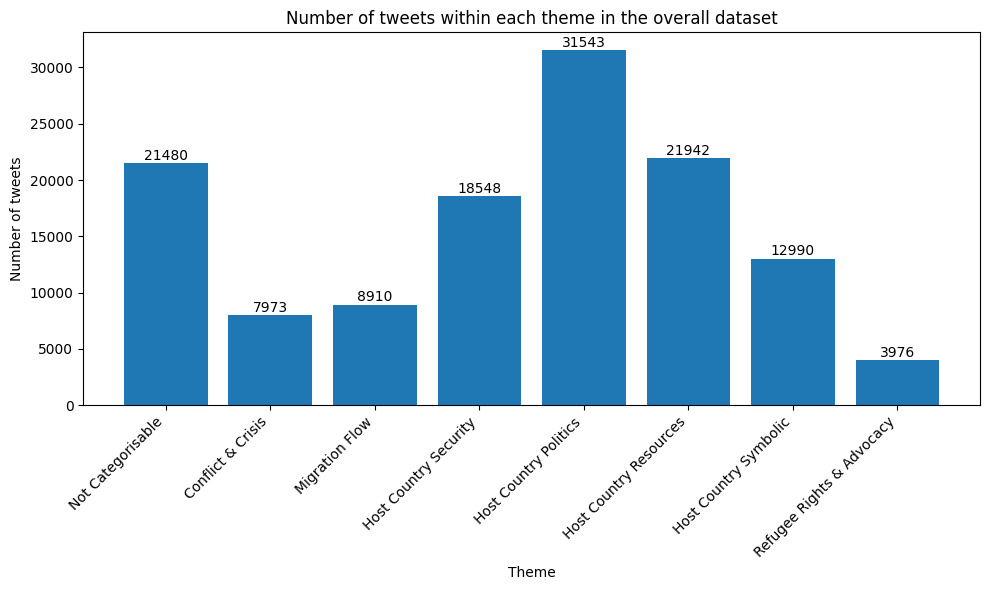

In [ ]:
#Number of tweets within each theme in the overall dataset


# Rearrange label_names for plotting with "Refugee Rights & Advocacy" at the end
label_names_reordered = label_names[:5] + label_names[6:] + [label_names[5]]

# Rearrange counts for plotting with the same order as label_names_reordered
counts_reordered = [df_lengths[name] for name in label_names_reordered]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names_reordered, counts_reordered, color='tab:blue')
plt.xlabel('Theme')
plt.ylabel('Number of tweets')
plt.title('Number of tweets within each theme in the overall dataset')
plt.xticks(rotation=45, ha='right')

# Adding number marks
for bar, count in zip(bars, counts_reordered):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 50,
             f'{count}',
             ha='center',
             va='bottom')

plt.tight_layout()
plt.show()

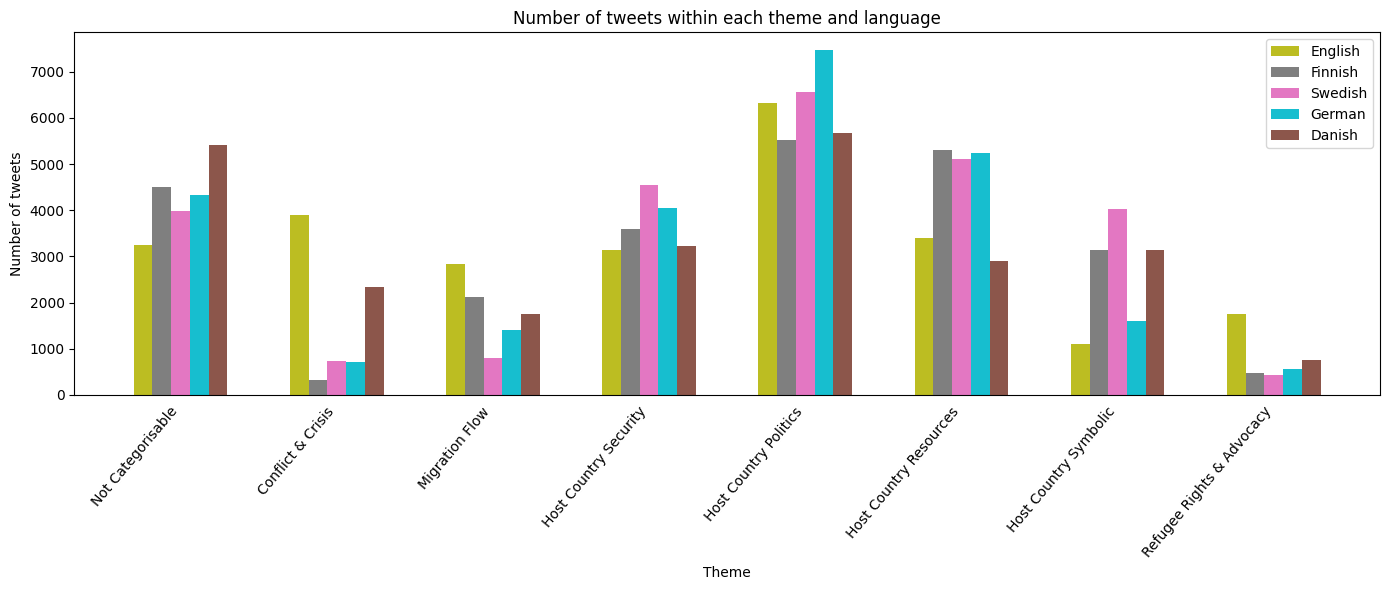

In [ ]:
#Prevalence of tweets within each theme and language

# Define language names
languages = df['Language'].unique()


# Plotting
plt.figure(figsize=(14, 6))
bar_width = 0.6 / len(languages)  # Adjust the width of each bar to accommodate all languages

colors = ['tab:olive', 'tab:gray', 'tab:pink', 'tab:cyan', 'tab:brown']
for idx, language in enumerate(languages):
    # Filter data for the current language
    language_df = df[df['Language'] == language]

    # Calculate lengths for the current language
    language_df_lengths = {name: len(filtered_dfs[name][filtered_dfs[name]['Language'] == language]) for name in label_names}

    # Extract counts in the reordered order
    counts = [language_df_lengths[name] for name in label_names_reordered]

    # Plotting for the current language
    x = [i + idx * bar_width for i in range(len(label_names_reordered))]
    plt.bar(x, counts, width=bar_width, label=language, color=colors[idx])

plt.xlabel('Theme')
plt.ylabel('Number of tweets')
plt.title('Prevalence of tweets within each theme and language')
plt.xticks([i + (len(languages) - 1) * bar_width / 2 for i in range(len(label_names_reordered))], label_names_reordered, rotation=50, ha='right')
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.legend()
plt.tight_layout()
plt.show()


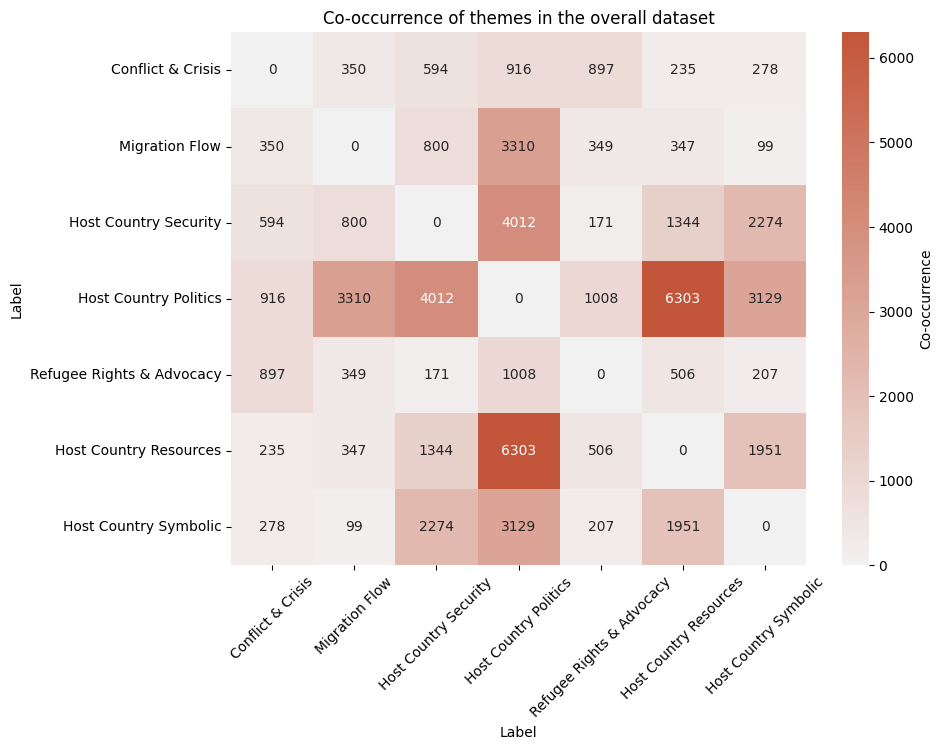

In [ ]:
# Co-occurrence of themes in the overall dataset


# Initialize co-occurrence matrix
co_occurrence_matrix = np.zeros((len(label_names) - 1, len(label_names) - 1), dtype=int)

# Iterate through each theme filtered dataframe excluding "Not Categorisable"
for i, label_name_i in enumerate(label_names):
    if label_name_i == 'Not Categorisable':
        continue
    for j, label_name_j in enumerate(label_names):
        if label_name_j == 'Not Categorisable':
            continue
        # Count the co-occurrence of label i and label j
        co_occurrence_matrix[i - 1, j - 1] = len(filtered_dfs[label_name_i][filtered_dfs[label_name_i].index.isin(filtered_dfs[label_name_j].index)])

# Create a DataFrame from the co-occurrence matrix
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=[label for label in label_names if label != 'Not Categorisable'], columns=[label for label in label_names if label != 'Not Categorisable'])

# Create custom colormap
cmap = sns.diverging_palette(240, 20, as_cmap=True)

# Modify the diagonal (where theme = theme)
np.fill_diagonal(co_occurrence_matrix, 0)

# Plotting
plt.figure(figsize=(9.7,7.6))
sns.heatmap(co_occurrence_df, annot=True, cmap=cmap, fmt="d", center=0, cbar_kws={'label': 'Co-occurrence'})
plt.title("Co-occurrence of themes in the overall dataset")
plt.xlabel("Label")
plt.ylabel("Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# English analysis

In [ ]:
# filtering on a language
df_country = df[df['Language'] == 'English']

filtered_dfs = {}

for i, label_name in enumerate(label_names):
    if label_name == 'Not Categorisable':
        # Merge 'No Label' into 'Not Categorisable'
        filtered_dfs[label_name] = pd.concat([df_country[df_country['predicted_label'].apply(lambda x: x[i] == 1)],
                                              df_country[df_country['predicted_label'].apply(lambda x: all(j == 0 for j in x))]])
    else:
        filtered_dfs[label_name] = df_country[df_country['predicted_label'].apply(lambda x: x[i] == 1)]

# Calculate the lengths
df_lengths = {name: len(filtered_dfs[name]) for name in label_names}

# Sort by length
sorted_df_lengths = sorted(df_lengths.items(), key=lambda x: x[1], reverse=True)

# Print in sorted order
for name, length in sorted_df_lengths:
    print(f"{name}:", length)
labels, counts = zip(*sorted_df_lengths)

Host Country Politics: 6319
Conflict & Crisis: 3886
Host Country Resources: 3398
Not Categorisable: 3248
Host Country Security: 3134
Migration Flow: 2843
Refugee Rights & Advocacy: 1745
Host Country Symbolic: 1110


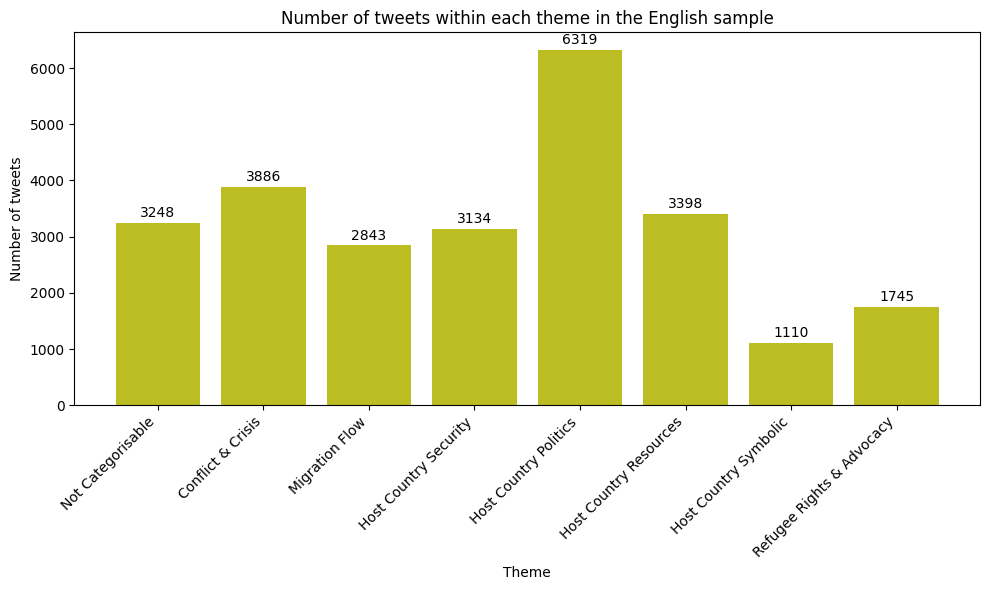

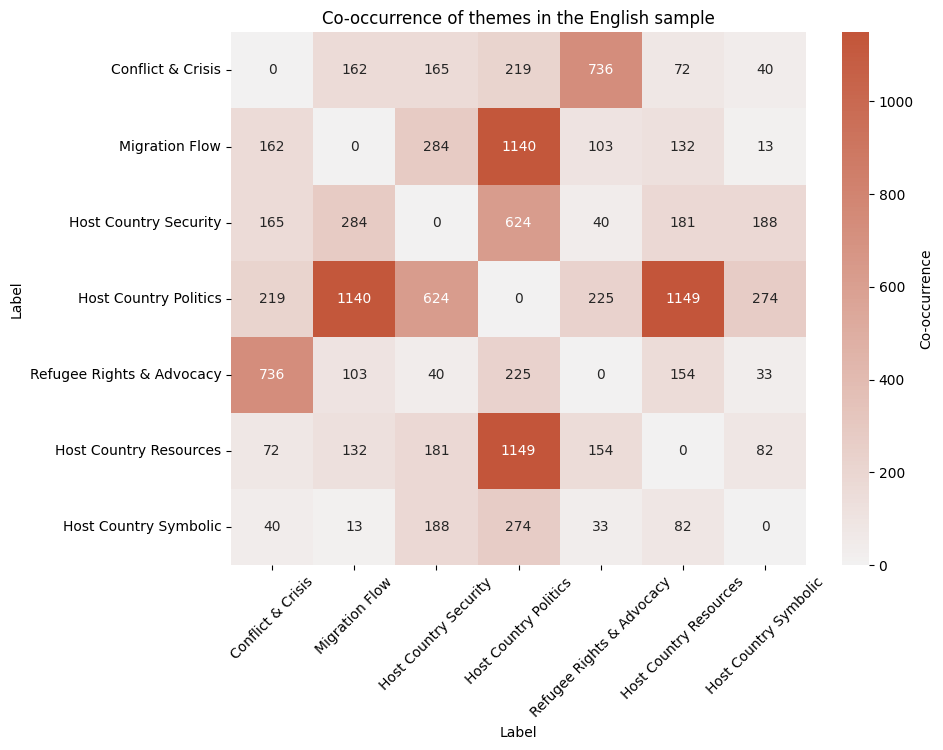

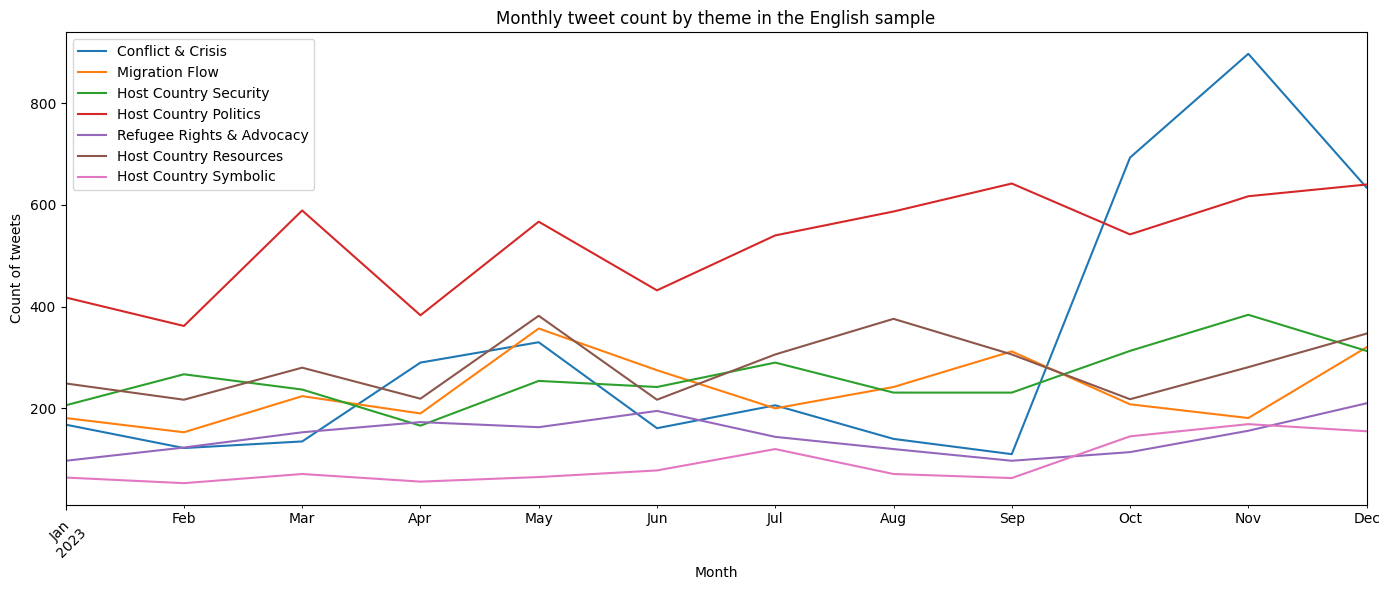

In [ ]:
#PLOTTING


# Rearrange label_names for plotting with "Refugee Rights & Advocacy" at the end
label_names_reordered = label_names[:5] + label_names[6:] + [label_names[5]]
# Rearrange counts for plotting with the same order as label_names_reordered
counts_reordered = [df_lengths[name] for name in label_names_reordered]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names_reordered, counts_reordered, color='tab:olive')
plt.xlabel('Theme')
plt.ylabel('Number of tweets')
plt.title('Number of tweets within each theme in the English sample')
plt.xticks(rotation=45, ha='right')

# Adding number marks
for bar, count in zip(bars, counts_reordered):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 50,
             f'{count}',
             ha='center',
             va='bottom')

plt.tight_layout()
plt.show()

############################################################
# Initialize co-occurrence matrix
co_occurrence_matrix = np.zeros((len(label_names) - 1, len(label_names) - 1), dtype=int)

# Iterate through each filtered dataframe excluding "Not Categorisable"
for i, label_name_i in enumerate(label_names):
    if label_name_i == 'Not Categorisable':
        continue
    for j, label_name_j in enumerate(label_names):
        if label_name_j == 'Not Categorisable':
            continue
        # Count the co-occurrence of label i and label j
        co_occurrence_matrix[i - 1, j - 1] = len(filtered_dfs[label_name_i][filtered_dfs[label_name_i].index.isin(filtered_dfs[label_name_j].index)])

# Create a DataFrame from the co-occurrence matrix
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=[label for label in label_names if label != 'Not Categorisable'], columns=[label for label in label_names if label != 'Not Categorisable'])

# Create custom colormap
cmap = sns.diverging_palette(240, 20, as_cmap=True)

# Modify the diagonal (where theme = theme)
np.fill_diagonal(co_occurrence_matrix, 0)

# Plot heatmap
plt.figure(figsize=(9.7,7.6))
sns.heatmap(co_occurrence_df, annot=True, cmap=cmap, fmt="d", center=0, cbar_kws={'label': 'Co-occurrence'})
plt.title("Co-occurrence of themes in the English sample")
plt.xlabel("Label")
plt.ylabel("Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

############################################################
#Monthly tweet count by theme
plt.figure(figsize=(14, 6))

for label, d in filtered_dfs.items():
    if label == 'Not Categorisable' or label == 'No Label':
        continue

    df_indexed = d.set_index('Date')
    counts_by_month = df_indexed.resample('M').size()

    # Plot the monthly counts
    counts_by_month.plot(label=label)

plt.title('Monthly tweet count by theme in the English sample')
plt.xlabel('Month')
plt.ylabel('Count of tweets')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Danish analysis

In [ ]:
# filtering on a language
df_country = df[df['Language'] == 'Danish']

filtered_dfs = {}

for i, label_name in enumerate(label_names):
    if label_name == 'Not Categorisable':
        # Merge 'No Label' into 'Not Categorisable'
        filtered_dfs[label_name] = pd.concat([df_country[df_country['predicted_label'].apply(lambda x: x[i] == 1)],
                                              df_country[df_country['predicted_label'].apply(lambda x: all(j == 0 for j in x))]])
    else:
        filtered_dfs[label_name] = df_country[df_country['predicted_label'].apply(lambda x: x[i] == 1)]

# Calculate the lengths
df_lengths = {name: len(filtered_dfs[name]) for name in label_names}

# Sort by length
sorted_df_lengths = sorted(df_lengths.items(), key=lambda x: x[1], reverse=True)

# Print in sorted order
for name, length in sorted_df_lengths:
    print(f"{name}:", length)  # Extract labels and counts from sorted_df_lengths
labels, counts = zip(*sorted_df_lengths)

Host Country Politics: 5677
Not Categorisable: 5415
Host Country Security: 3218
Host Country Symbolic: 3128
Host Country Resources: 2895
Conflict & Crisis: 2336
Migration Flow: 1742
Refugee Rights & Advocacy: 756


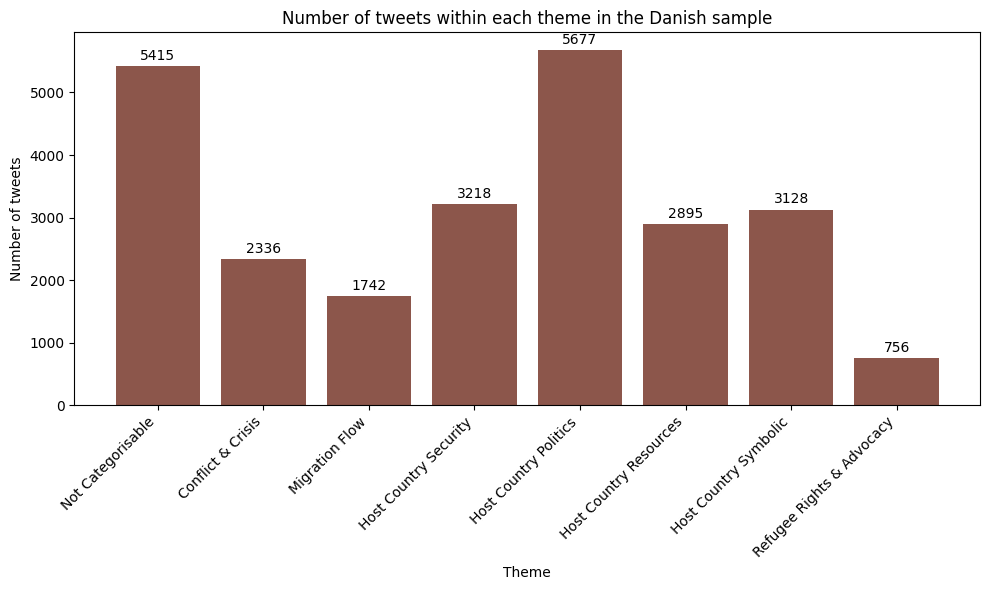

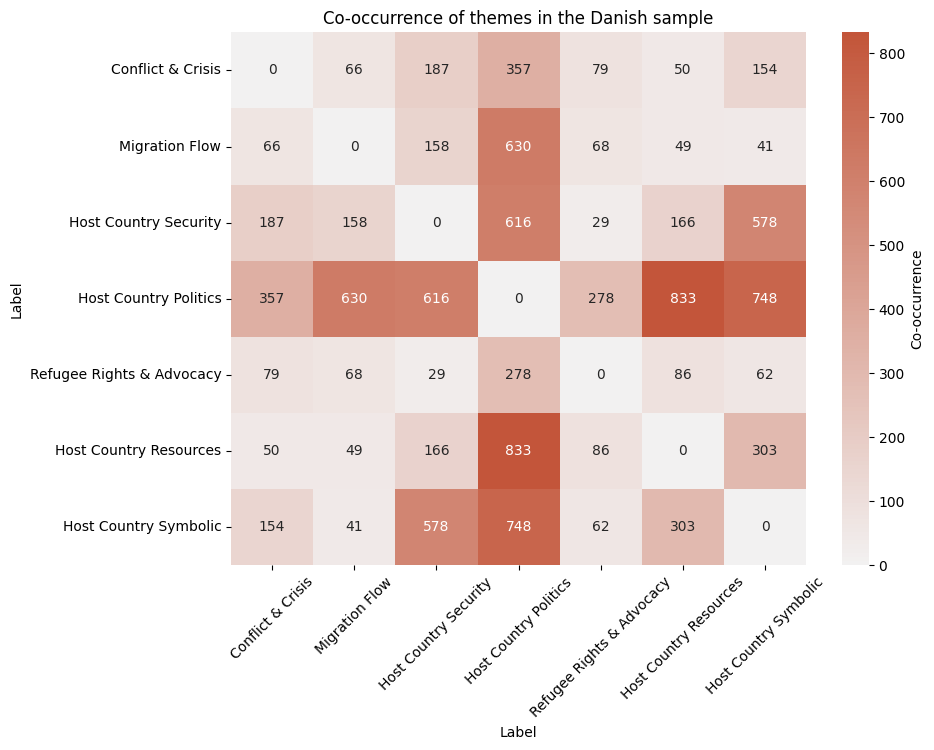

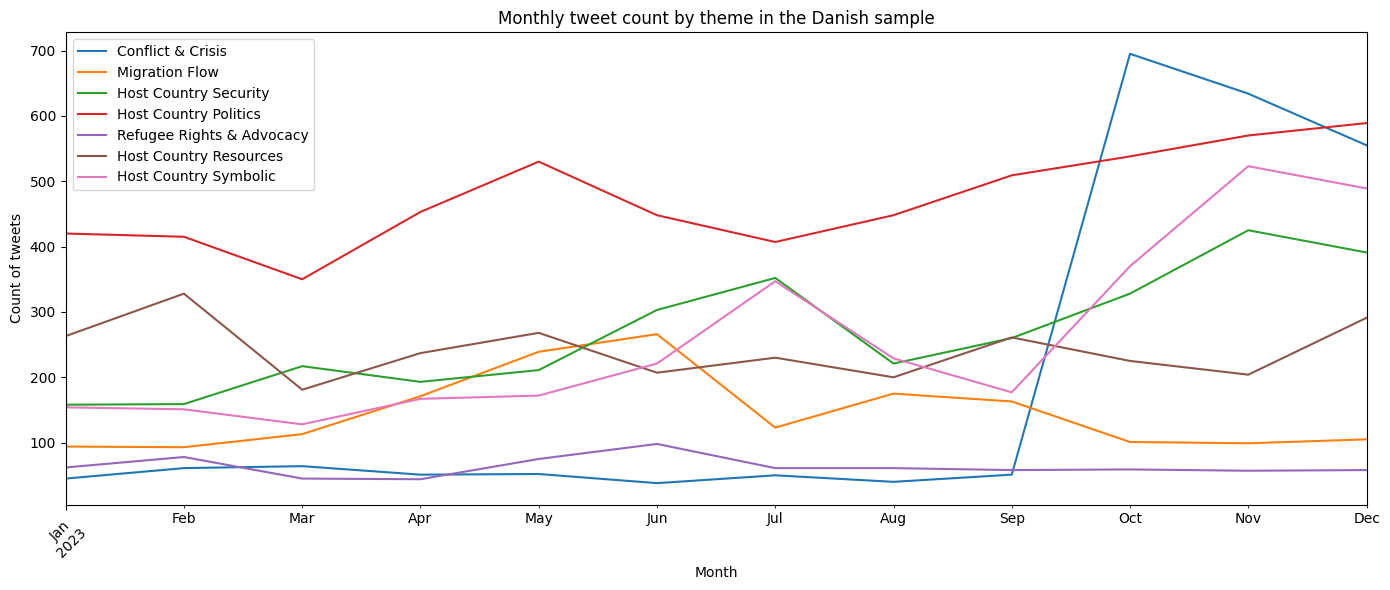

In [ ]:
#PLOTTING


# Rearrange label_names for plotting with "Refugee Rights & Advocacy" at the end
label_names_reordered = label_names[:5] + label_names[6:] + [label_names[5]]

# Rearrange counts for plotting with the same order as label_names_reordered
counts_reordered = [df_lengths[name] for name in label_names_reordered]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names_reordered, counts_reordered, color='tab:brown')
plt.xlabel('Theme')
plt.ylabel('Number of tweets')
plt.title('Number of tweets within each theme in the Danish sample')
plt.xticks(rotation=45, ha='right')

# Adding number marks
for bar, count in zip(bars, counts_reordered):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 50,
             f'{count}',
             ha='center',
             va='bottom')

plt.tight_layout()
plt.show()


############################################################
# Initialize co-occurrence matrix
co_occurrence_matrix = np.zeros((len(label_names) - 1, len(label_names) - 1), dtype=int)

# Iterate through each filtered dataframe excluding "Not Categorisable"
for i, label_name_i in enumerate(label_names):
    if label_name_i == 'Not Categorisable':
        continue
    for j, label_name_j in enumerate(label_names):
        if label_name_j == 'Not Categorisable':
            continue
        # Count the co-occurrence of label i and label j
        co_occurrence_matrix[i - 1, j - 1] = len(filtered_dfs[label_name_i][filtered_dfs[label_name_i].index.isin(filtered_dfs[label_name_j].index)])

# Create a DataFrame from the co-occurrence matrix
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=[label for label in label_names if label != 'Not Categorisable'], columns=[label for label in label_names if label != 'Not Categorisable'])

# Create custom colormap
cmap = sns.diverging_palette(240, 20, as_cmap=True)

# Modify the diagonal (where theme = theme)
np.fill_diagonal(co_occurrence_matrix, 0)

# Plot heatmap
plt.figure(figsize=(9.7,7.6))
sns.heatmap(co_occurrence_df, annot=True, cmap=cmap, fmt="d", center=0, cbar_kws={'label': 'Co-occurrence'})
plt.title("Co-occurrence of themes in the Danish sample")
plt.xlabel("Label")
plt.ylabel("Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

############################################################
#Monthly tweet count by theme
plt.figure(figsize=(14, 6))

for label, d in filtered_dfs.items():
    if label == 'Not Categorisable' or label == 'No Label':
        continue

    df_indexed = d.set_index('Date')
    counts_by_month = df_indexed.resample('M').size()

    # Plot the monthly counts
    counts_by_month.plot(label=label)


plt.title('Monthly tweet count by theme in the Danish sample')
plt.xlabel('Month')
plt.ylabel('Count of tweets')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Swedish analysis

In [ ]:
# filtering on a language
df_country = df[df['Language'] == 'Swedish']

filtered_dfs = {}

for i, label_name in enumerate(label_names):
    if label_name == 'Not Categorisable':
        # Merge 'No Label' into 'Not Categorisable'
        filtered_dfs[label_name] = pd.concat([df_country[df_country['predicted_label'].apply(lambda x: x[i] == 1)],
                                              df_country[df_country['predicted_label'].apply(lambda x: all(j == 0 for j in x))]])
    else:
        filtered_dfs[label_name] = df_country[df_country['predicted_label'].apply(lambda x: x[i] == 1)]

# Calculate the lengths
df_lengths = {name: len(filtered_dfs[name]) for name in label_names}

# Sort by length
sorted_df_lengths = sorted(df_lengths.items(), key=lambda x: x[1], reverse=True)

# Print in sorted order
for name, length in sorted_df_lengths:
    print(f"{name}:", length)  # Extract labels and counts from sorted_df_lengths
labels, counts = zip(*sorted_df_lengths)

Host Country Politics: 6558
Host Country Resources: 5113
Host Country Security: 4545
Host Country Symbolic: 4016
Not Categorisable: 3981
Migration Flow: 796
Conflict & Crisis: 723
Refugee Rights & Advocacy: 431


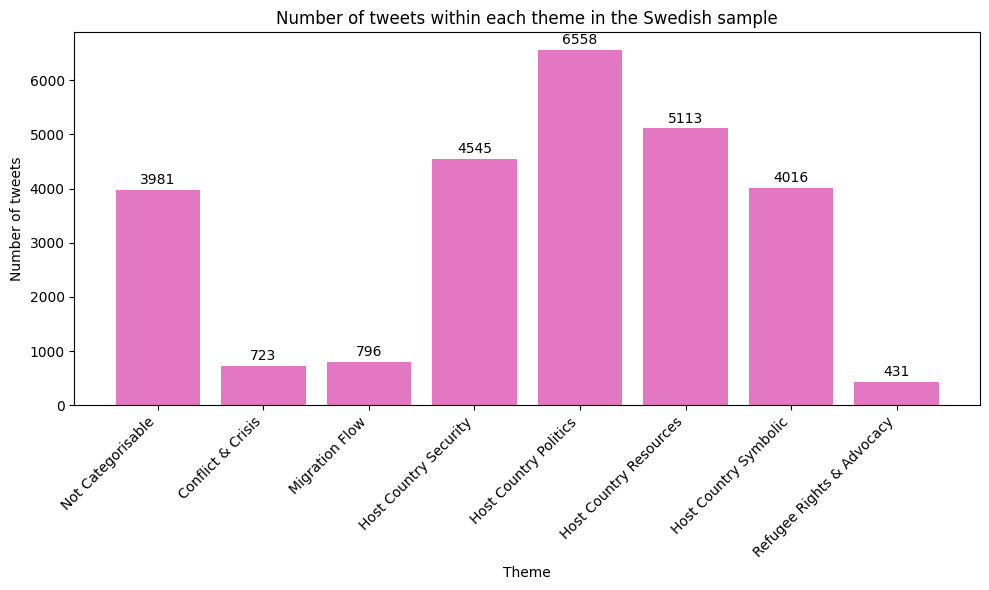

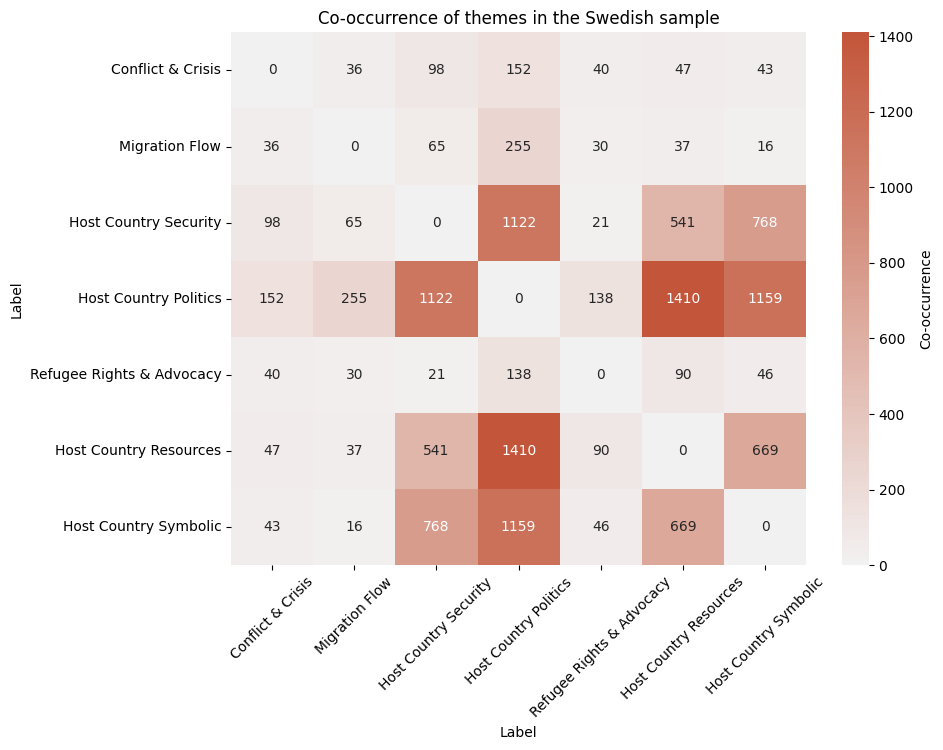

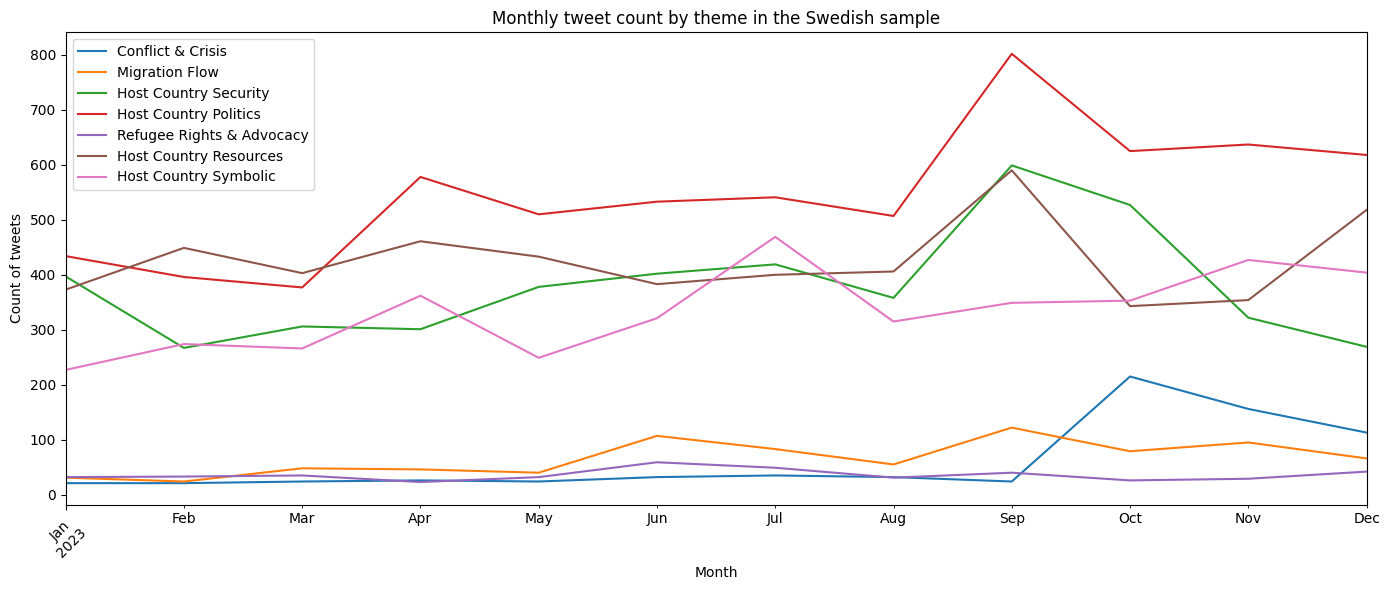

In [ ]:
#PLOTTING

# Rearrange label_names for plotting with "Refugee Rights & Advocacy" at the end
label_names_reordered = label_names[:5] + label_names[6:] + [label_names[5]]

# Rearrange counts for plotting with the same order as label_names_reordered
counts_reordered = [df_lengths[name] for name in label_names_reordered]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names_reordered, counts_reordered, color='tab:pink')
plt.xlabel('Theme')
plt.ylabel('Number of tweets')
plt.title('Number of tweets within each theme in the Swedish sample')
plt.xticks(rotation=45, ha='right')

# Adding number marks
for bar, count in zip(bars, counts_reordered):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 50,
             f'{count}',
             ha='center',
             va='bottom')

plt.tight_layout()
plt.show()


############################################################
# Initialize co-occurrence matrix
co_occurrence_matrix = np.zeros((len(label_names) - 1, len(label_names) - 1), dtype=int)

# Iterate through each filtered dataframe excluding "Not Categorisable"
for i, label_name_i in enumerate(label_names):
    if label_name_i == 'Not Categorisable':
        continue
    for j, label_name_j in enumerate(label_names):
        if label_name_j == 'Not Categorisable':
            continue
        # Count the co-occurrence of label i and label j
        co_occurrence_matrix[i - 1, j - 1] = len(filtered_dfs[label_name_i][filtered_dfs[label_name_i].index.isin(filtered_dfs[label_name_j].index)])

# Create a DataFrame from the co-occurrence matrix
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=[label for label in label_names if label != 'Not Categorisable'], columns=[label for label in label_names if label != 'Not Categorisable'])

# Create custom colormap
cmap = sns.diverging_palette(240, 20, as_cmap=True)

# Modify the diagonal (where theme = theme)
np.fill_diagonal(co_occurrence_matrix, 0)

# Plot heatmap
plt.figure(figsize=(9.7,7.6))
sns.heatmap(co_occurrence_df, annot=True, cmap=cmap, fmt="d", center=0, cbar_kws={'label': 'Co-occurrence'})
plt.title("Co-occurrence of themes in the Swedish sample")
plt.xlabel("Label")
plt.ylabel("Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


############################################################
#Monthly tweet count by theme
plt.figure(figsize=(14, 6))

for label, d in filtered_dfs.items():
    if label == 'Not Categorisable' or label == 'No Label':
        continue

    df_indexed = d.set_index('Date')
    counts_by_month = df_indexed.resample('M').size()

    # Plot the monthly counts
    counts_by_month.plot(label=label)

plt.title('Monthly tweet count by theme in the Swedish sample')
plt.xlabel('Month')
plt.ylabel('Count of tweets')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Finnish analysis

In [ ]:
# filtering on a language
df_country = df[df['Language'] == 'Finnish']

filtered_dfs = {}

for i, label_name in enumerate(label_names):
    if label_name == 'Not Categorisable':
        # Merge 'No Label' into 'Not Categorisable'
        filtered_dfs[label_name] = pd.concat([df_country[df_country['predicted_label'].apply(lambda x: x[i] == 1)],
                                              df_country[df_country['predicted_label'].apply(lambda x: all(j == 0 for j in x))]])
    else:
        filtered_dfs[label_name] = df_country[df_country['predicted_label'].apply(lambda x: x[i] == 1)]

# Calculate the lengths
df_lengths = {name: len(filtered_dfs[name]) for name in label_names}

# Sort by length
sorted_df_lengths = sorted(df_lengths.items(), key=lambda x: x[1], reverse=True)

# Print in sorted order
for name, length in sorted_df_lengths:
    print(f"{name}:", length)  # Extract labels and counts from sorted_df_lengths
labels, counts = zip(*sorted_df_lengths)

Host Country Politics: 5510
Host Country Resources: 5300
Not Categorisable: 4504
Host Country Security: 3600
Host Country Symbolic: 3130
Migration Flow: 2123
Refugee Rights & Advocacy: 483
Conflict & Crisis: 312


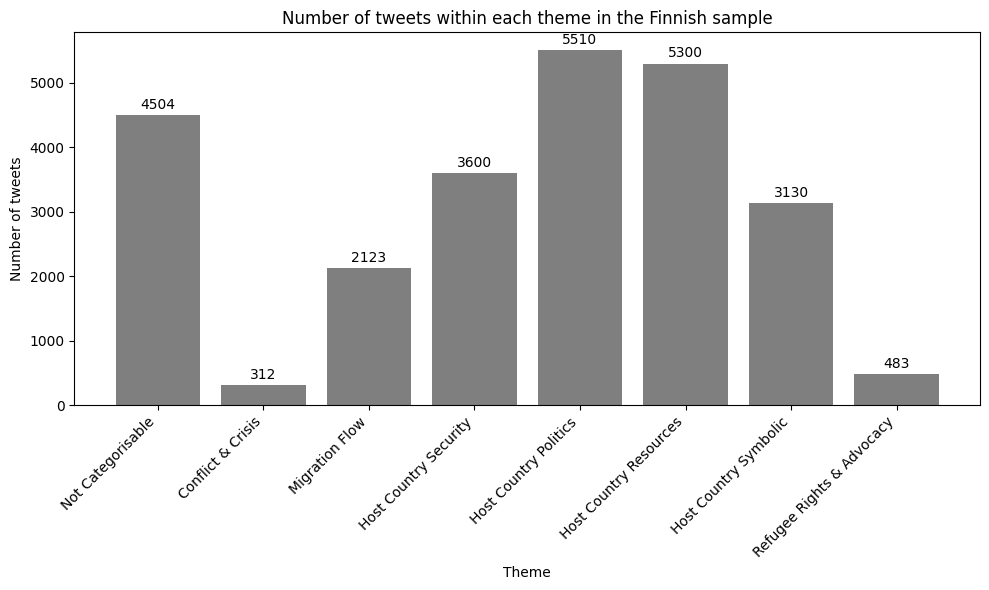

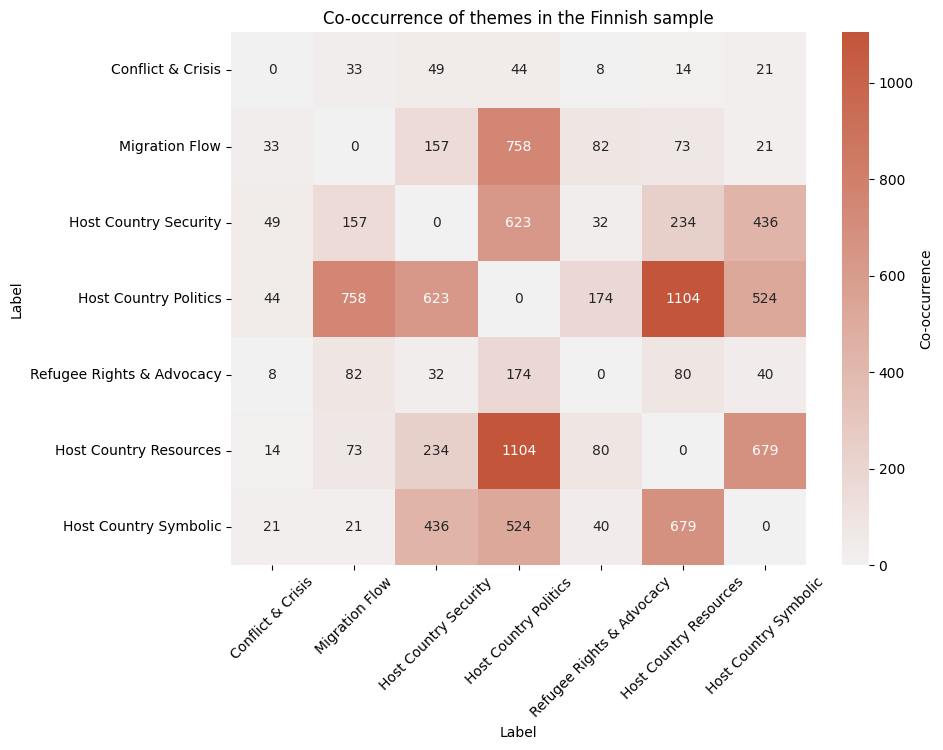

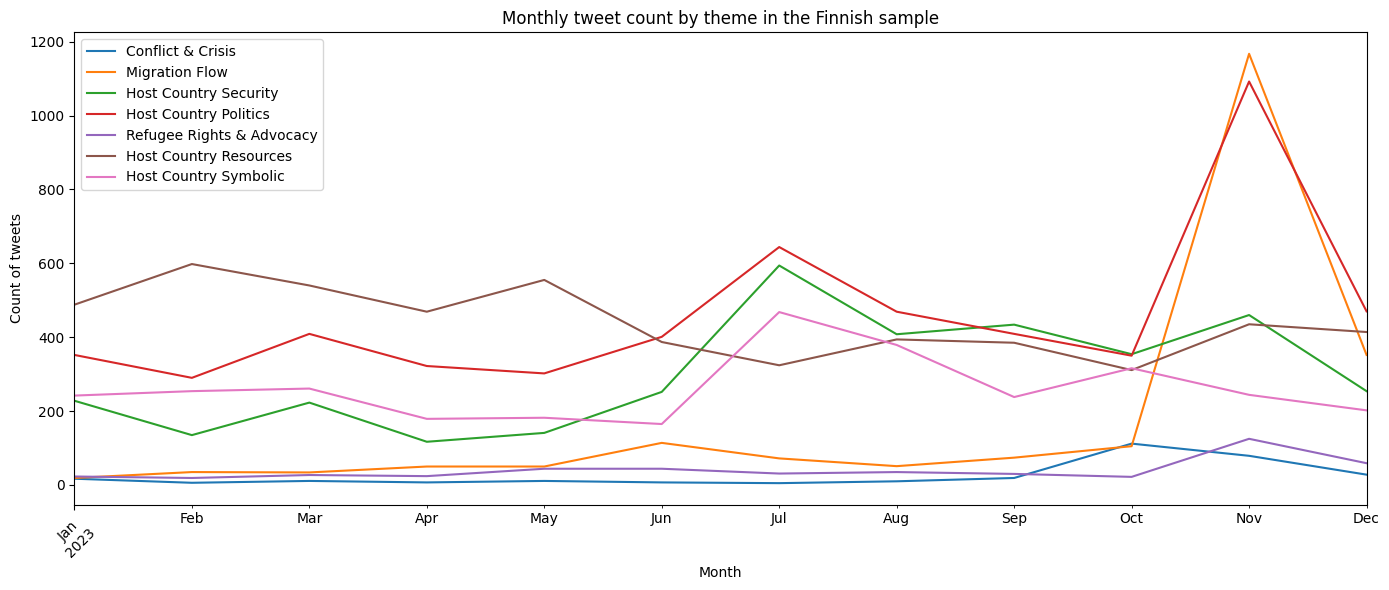

In [ ]:
#PLOTTING

# Rearrange label_names for plotting with "Refugee Rights & Advocacy" at the end
label_names_reordered = label_names[:5] + label_names[6:] + [label_names[5]]

# Rearrange counts for plotting with the same order as label_names_reordered
counts_reordered = [df_lengths[name] for name in label_names_reordered]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names_reordered, counts_reordered, color='tab:grey')
plt.xlabel('Theme')
plt.ylabel('Number of tweets')
plt.title('Number of tweets within each theme in the Finnish sample')
plt.xticks(rotation=45, ha='right')

# Adding number marks
for bar, count in zip(bars, counts_reordered):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 50,
             f'{count}',
             ha='center',
             va='bottom')

plt.tight_layout()
plt.show()


############################################################
# Initialize co-occurrence matrix
co_occurrence_matrix = np.zeros((len(label_names) - 1, len(label_names) - 1), dtype=int)

# Iterate through each filtered dataframe excluding "Not Categorisable"
for i, label_name_i in enumerate(label_names):
    if label_name_i == 'Not Categorisable':
        continue
    for j, label_name_j in enumerate(label_names):
        if label_name_j == 'Not Categorisable':
            continue
        # Count the co-occurrence of label i and label j
        co_occurrence_matrix[i - 1, j - 1] = len(filtered_dfs[label_name_i][filtered_dfs[label_name_i].index.isin(filtered_dfs[label_name_j].index)])

# Create a DataFrame from the co-occurrence matrix
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=[label for label in label_names if label != 'Not Categorisable'], columns=[label for label in label_names if label != 'Not Categorisable'])

# Create custom colormap
cmap = sns.diverging_palette(240, 20, as_cmap=True)

# Modify the diagonal (where theme = theme)
np.fill_diagonal(co_occurrence_matrix, 0)

# Plot heatmap
plt.figure(figsize=(9.7,7.6))
sns.heatmap(co_occurrence_df, annot=True, cmap=cmap, fmt="d", center=0, cbar_kws={'label': 'Co-occurrence'})
plt.title("Co-occurrence of themes in the Finnish sample")
plt.xlabel("Label")
plt.ylabel("Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


############################################################
#Monthly tweet count by theme
plt.figure(figsize=(14, 6))

for label, d in filtered_dfs.items():
    if label == 'Not Categorisable' or label == 'No Label':
        continue

    df_indexed = d.set_index('Date')
    counts_by_month = df_indexed.resample('M').size()

    # Plot the monthly counts
    counts_by_month.plot(label=label)

plt.title('Monthly tweet count by theme in the Finnish sample')
plt.xlabel('Month')
plt.ylabel('Count of tweets')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# German analysis

In [ ]:
# filtering on a language
df_country = df[df['Language'] == 'German']

filtered_dfs = {}

for i, label_name in enumerate(label_names):
    if label_name == 'Not Categorisable':
        # Merge 'No Label' into 'Not Categorisable'
        filtered_dfs[label_name] = pd.concat([df_country[df_country['predicted_label'].apply(lambda x: x[i] == 1)],
                                              df_country[df_country['predicted_label'].apply(lambda x: all(j == 0 for j in x))]])
    else:
        filtered_dfs[label_name] = df_country[df_country['predicted_label'].apply(lambda x: x[i] == 1)]

# Calculate the lengths
df_lengths = {name: len(filtered_dfs[name]) for name in label_names}

# Sort by length
sorted_df_lengths = sorted(df_lengths.items(), key=lambda x: x[1], reverse=True)

# Print in sorted order
for name, length in sorted_df_lengths:
    print(f"{name}:", length)
labels, counts = zip(*sorted_df_lengths)

Host Country Politics: 7479
Host Country Resources: 5236
Not Categorisable: 4332
Host Country Security: 4051
Host Country Symbolic: 1606
Migration Flow: 1406
Conflict & Crisis: 716
Refugee Rights & Advocacy: 561


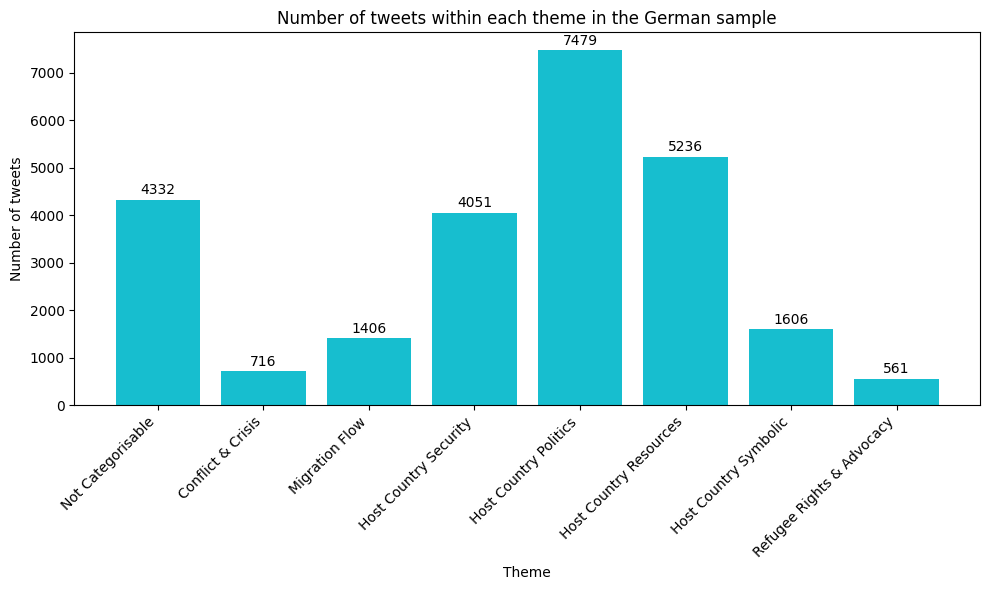

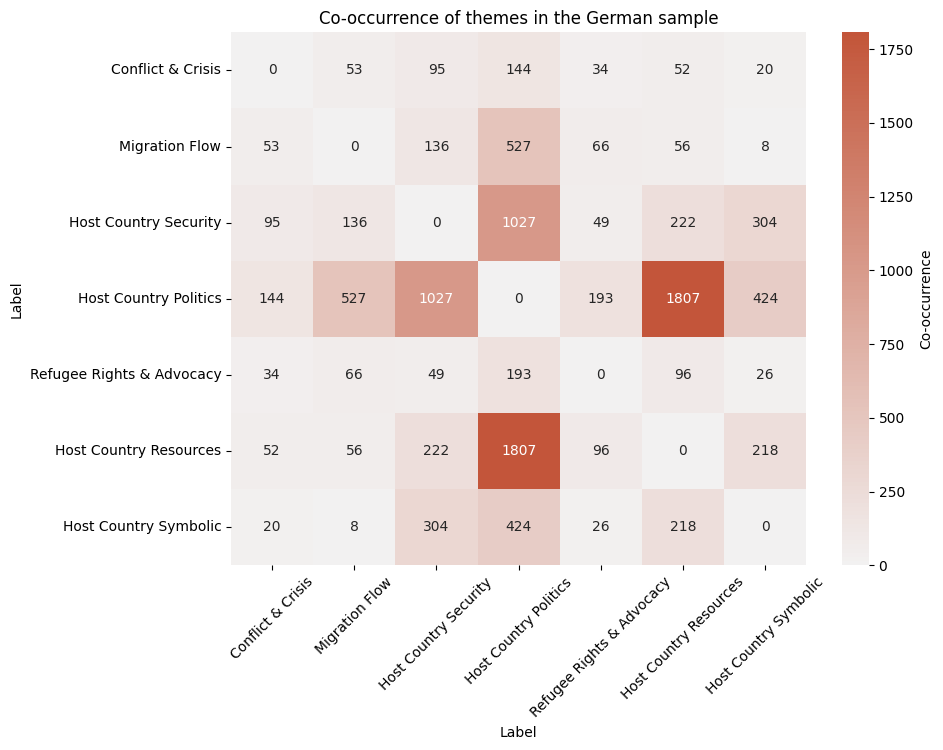

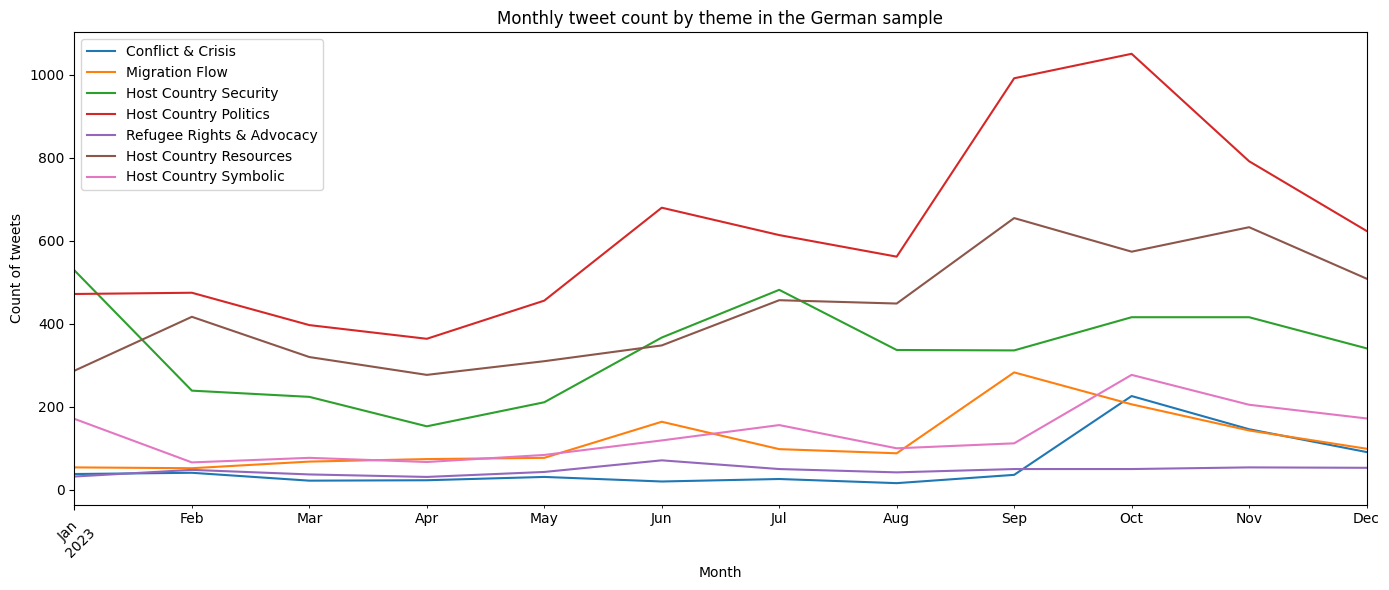

In [ ]:
#PLOTTING
# Rearrange label_names for plotting with "Refugee Rights & Advocacy" at the end
label_names_reordered = label_names[:5] + label_names[6:] + [label_names[5]]

# Rearrange counts for plotting with the same order as label_names_reordered
counts_reordered = [df_lengths[name] for name in label_names_reordered]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names_reordered, counts_reordered, color='tab:cyan')
plt.xlabel('Theme')
plt.ylabel('Number of tweets')
plt.title('Number of tweets within each theme in the German sample')
plt.xticks(rotation=45, ha='right')

# Adding number marks
for bar, count in zip(bars, counts_reordered):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 50,
             f'{count}',
             ha='center',
             va='bottom')

plt.tight_layout()
plt.show()


############################################################
# Initialize co-occurrence matrix
co_occurrence_matrix = np.zeros((len(label_names) - 1, len(label_names) - 1), dtype=int)

# Iterate through each filtered dataframe excluding "Not Categorisable"
for i, label_name_i in enumerate(label_names):
    if label_name_i == 'Not Categorisable':
        continue
    for j, label_name_j in enumerate(label_names):
        if label_name_j == 'Not Categorisable':
            continue
        # Count the co-occurrence of label i and label j
        co_occurrence_matrix[i - 1, j - 1] = len(filtered_dfs[label_name_i][filtered_dfs[label_name_i].index.isin(filtered_dfs[label_name_j].index)])

# Create a DataFrame from the co-occurrence matrix
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=[label for label in label_names if label != 'Not Categorisable'], columns=[label for label in label_names if label != 'Not Categorisable'])

# Create custom colormap
cmap = sns.diverging_palette(240, 20, as_cmap=True)

# Modify the diagonal (where theme = theme)
np.fill_diagonal(co_occurrence_matrix, 0)

# Plot heatmap
plt.figure(figsize=(9.7,7.6))
sns.heatmap(co_occurrence_df, annot=True, cmap=cmap, fmt="d", center=0, cbar_kws={'label': 'Co-occurrence'})
plt.title("Co-occurrence of themes in the German sample")
plt.xlabel("Label")
plt.ylabel("Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

############################################################
#Monthly tweet count by theme
plt.figure(figsize=(14, 6))

for label, d in filtered_dfs.items():
    if label == 'Not Categorisable' or label == 'No Label':
        continue

    df_indexed = d.set_index('Date')
    counts_by_month = df_indexed.resample('M').size()

    # Plot the monthly counts
    counts_by_month.plot(label=label)

plt.title('Monthly tweet count by theme in the German sample')
plt.xlabel('Month')
plt.ylabel('Count of tweets')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()